In [0]:
import tensorflow as tf 
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
#import tensorflow.contrib.eager as tfe
import numpy as np 
tf.enable_eager_execution()

In [0]:
class Encoder(tf.keras.Model):
	def __init__(self, hidden_size=512):
		super(Encoder, self).__init__()
		self.encoder = LSTM(hidden_size, return_sequence = True, return_state = True)

	def call(self, x):
		e, state_h, state_c  = self.encoder(x)        
		return e, [state_h, state_c]

class Decoder(tf.keras.Model):
	def __init__(self, hidden_size=512):
		super(Decoder, self).__init__()
		self.decoder = LSTM(hidden_size, return_sequence = True, return_state = True)

	def call(self, x, hidden_states):
		d, state_h, state_c  = self.decoder(x, initial_state=hidden_states)
		return d, [state_h, state_c]

class PtrnetLSTM(tf.keras.Model):
	def __init__(self, hidden_size=512):
		super(PtrnetLSTM, self).__init__()
		#self.W1 = tfe.variable(tf.random_uniform([hidden_size, hidden_size], -0.08, 0.08), dtype=float32)
		self.W1 = tf.keras.layers.Dense(hidden_size, kernel_initializer= tf.keras.initializers.RandomUniform(minval = -0.08, maxval = 0.08, seed = None), use_bias=False)
		self.W2 = tf.keras.layers.Dense(hidden_size, kernel_initializer= tf.keras.initializers.RandomUniform(minval = -0.08, maxval = 0.08, seed = None), use_bias=False)
		#Dense layer -> dot(input, kernel) -> so now Ui = vT . tanh(W1 . e + W2 . di)  becomes Ui = tanh(e . W1 + di . W2) . v
		self.VT = tf.keras.layers.Dense(1, use_bias=False)
	# e= encoder output and d = decoder output
	def call(self, e,d):
		u = self.VT(tf.nn.tanh(self.W1(e) + self.W2(d)))
		attention = tf.nn.softmax(u, axis = 1)

		return tf.reshape(attention, attention.shape[0], attention.shape[1])


In [0]:

class fastweights(tf.keras.Model):
	def __init__(self, input_dim, elemnum , batch_size=128, decay_rate = 0.9, learning_rate = 0.5, hidden_size=512):
		super(fastweights, self).__init__()
		self.batch_size = batch_size
		self.DR = decay_rate
		self.LR = learning_rate
		self.hidden_size = hidden_size
		self.W_x = tf.Variable(tf.random_uniform([elemnum, hidden_size], -np.sqrt(2/elemnum), np.sqrt(2/elemnum)), dtype=tf.float32)
		self.B_x = tf.Variable(tf.zeros(hidden_size), dtype=tf.float32)
		self.W_h = tf.Variable(initial_value = 0.5 * np.identity(hidden_size), dtype = tf.float32)
		self.W_y = tf.Variable(tf.random_uniform([hidden_size, elemnum], -np.sqrt(2/hidden_size), np.sqrt(2/hidden_size)), dtype = tf.float32)
		self.B_y = tf.Variable(tf.zeros(elemnum), dtype= tf.float32)
		self.scale = tf.Variable(tf.ones(hidden_size), dtype = tf.float32)
		self.shift = tf.Variable(tf.zeros(hidden_size), dtype = tf.float32) 
		#initial values of A and H matricies
		self.A = tf.zeros([self.batch_size, self.hidden_size,self.hidden_size], dtype = tf.float32)
		self.H = tf.zeros([self.batch_size, self.hidden_size], dtype = tf.float32)
    
	def call(self,X, S=1):
		X = tf.cast(X, tf.float32)
		for t in range(tf.shape(X)[1]):
			#first hidden state, A and H_s are  zero at this point so the part A(t)H_s(t+1) becomes zero
			self.H = tf.nn.relu((tf.matmul(self.H,self.W_h))+(tf.matmul(X[:, t, :],self.W_x)+self.B_x))
			#reshaping to use it with A, to calculate the A(t)H_s(t+1)
			H_s = tf.reshape(self.H, [self.batch_size, 1, self.hidden_size])
			#Initial A for this particular time step: A(t) = decay*A(t-1)+ learning*h(t)h(t).T
			#self.A = tf.add((tf.scalar_mul(self.DR, self.A)),(tf.batch_matmul(tf.transpose(self.H_s, [0,2,1]),self.H_s)))
			self.A = (tf.scalar_mul(self.DR, self.A))+ tf.scalar_mul(self.LR,(tf.matmul(tf.transpose(H_s, [0,2,1]),H_s)))
			#inner loop for fast weights, tfor S steps
			for _ in range(S):
				#calculating H_s without the non linearity first, so we can use linear normalization 
				H_s = tf.reshape(tf.matmul(self.H,self.W_h),tf.shape(H_s)) + tf.reshape(tf.matmul(X[:,t,:],self.W_x)+self.B_x,tf.shape(H_s)) + tf.matmul(H_s, self.A)
				#Applying Layer Normalization 
				mean, var = tf.nn.moments(H_s, axes =2, keep_dims = True)
				H_s = (self.scale*(H_s - mean))/(tf.sqrt(var + 1e-5) + self.shift)
				#applying non linearity
				H_s = tf.nn.relu(H_s)
			self.H = tf.reshape(H_s,[self.batch_size, self.hidden_size])
		finallayer = tf.matmul(self.H, self.W_y) + self.B_y
		return finallayer, self.H

In [0]:
import random


def get_three_letters():
    """
    Retrieve three random letters (a-z)
    without replacement.
    """
    return np.random.choice(range(0,26), 3, replace=False)

def get_three_numbers():
    """
    Retrieve three random numbers (0-9)
    with replacement.
    """
    return np.random.choice(range(26, 26+10), 3, replace=True)

def create_sequence():
    """
    Concatenate keys and values with
    ?? and one of the keys.
    Returns the input and output.
    """
    letters = get_three_letters()
    numbers = get_three_numbers()
    X = np.zeros((9))
    y = np.zeros((1))
    for i in range(0, 5, 2):
        X[i] = letters[int(i/2)]
        X[i+1] = numbers[int(i/2)]

    # append ??
    X[6] = 26+10
    X[7] = 26+10

    # last key and respective value (y)
    index = np.random.choice(range(0,3), 1, replace=False)
    X[8] = letters[index]
    y = numbers[index]

    # one hot encode X and y
    X_one_hot = np.eye(26+10+1)[np.array(X).astype('int')]
    y_one_hot = np.eye(26+10+1)[y][0]

    return X_one_hot, y_one_hot

def ordinal_to_alpha(sequence):
    """
    Convert from ordinal to alpha-numeric representations.
    Just for funsies :)
    """
    corpus = ['a','b','c','d','e','f','g','h','i','j','k','l',
              'm','n','o','p','q','r','s','t','u','v','w','x','y','z',
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '?']

    conversion = ""
    for item in sequence:
        conversion += str(corpus[int(item)])
    return conversion

def create_data(num_samples):
    """
    Create a num_samples long set of X and y.
    """
    X = np.zeros([num_samples, 9, 26+10+1], dtype=np.int32)
    y = np.zeros([num_samples, 26+10+1], dtype=np.int32)
    for i in range(num_samples):
        X[i], y[i] = create_sequence()
    return X, y

def generate_epoch(X, y, num_epochs, batch_size):

    for epoch_num in range(num_epochs):
        yield generate_batch(X, y, batch_size)

def generate_batch(X, y, batch_size):

    data_size = len(X)

    num_batches = (data_size // batch_size)
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        yield X[start_index:end_index], y[start_index:end_index]

# Sampling
sample_X, sample_y = create_sequence()
print ("Sample:", ordinal_to_alpha([np.argmax(X) for X in sample_X]), ordinal_to_alpha([np.argmax(sample_y)]))
# Train/valid sets
train_X, train_y = create_data(640)
print ("train_X:", np.shape(train_X), ",train_y:", np.shape(train_y))
valid_X, valid_y = create_data(384)
print ("valid_X:", np.shape(valid_X), ",valid_y:", np.shape(valid_y))
test_X, test_y = create_data(384)
print ("test_X:", np.shape(test_X), ",test_y:", np.shape(test_y))
    

Sample: u6y4j1??j 1
train_X: (640, 9, 37) ,train_y: (640, 37)
valid_X: (384, 9, 37) ,valid_y: (384, 37)
test_X: (384, 9, 37) ,test_y: (384, 37)


In [0]:
lr = tf.Variable(0.0, trainable = False)
optimizer = tf.train.AdamOptimizer(0.1)
inputdim = 9
elem = 37
fw = fastweights(inputdim, elem, 128, 0.9, 0.5, 512)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=fw)

In [0]:
t_loss_history = []
  
for train_epoch_num, train_epoch in enumerate(generate_epoch(train_X, train_y, 500, 128)):
  print("Epoch number :", train_epoch_num)
  for train_batch_num, (batch_X, batch_y) in enumerate(train_epoch):
    loss = 0

    with tf.GradientTape() as tape:
      pred_y = fw(batch_X, batch_y, 1)
      loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y))
        
    batch_loss = (loss/128)
  #if train_batch_num %10 ==0:
  #print("\tEpoch {:03d}/{:03d}: Loss at step {:02d}: {:.9f}".format((train_epoch_num+1), 1000, train_batch_num, tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y)) ))
    t_loss_history.append(batch_loss.numpy())
    variables = fw.variables
    grads, norm =tf.clip_by_global_norm(tape.gradient(loss, variables), 0.25) 
    optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
  print("Epoch {:03d}/{:03d} completed \t - \tBatch loss: {:.9f}".format((train_epoch_num+1), 1000, tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y)) ))
#tf.contrib.eager.Saver(variables).save('trained.ckpt')
checkpoint.save('trained.ckpt')
print("Final loss for training  set: {:.9f}".format(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred_y, labels= batch_y))))

Epoch number : 0
Instructions for updating:
Colocations handled automatically by placer.
Epoch 001/1000 completed 	 - 	Batch loss: 4.029645443
Epoch number : 1
Epoch 002/1000 completed 	 - 	Batch loss: 7.132364273
Epoch number : 2
Epoch 003/1000 completed 	 - 	Batch loss: 14.067187309
Epoch number : 3
Epoch 004/1000 completed 	 - 	Batch loss: 19.636137009
Epoch number : 4
Epoch 005/1000 completed 	 - 	Batch loss: 23.782295227
Epoch number : 5
Epoch 006/1000 completed 	 - 	Batch loss: 27.654804230
Epoch number : 6
Epoch 007/1000 completed 	 - 	Batch loss: 31.752246857
Epoch number : 7
Epoch 008/1000 completed 	 - 	Batch loss: 31.392410278
Epoch number : 8
Epoch 009/1000 completed 	 - 	Batch loss: 33.001548767
Epoch number : 9
Epoch 010/1000 completed 	 - 	Batch loss: 25.920097351
Epoch number : 10
Epoch 011/1000 completed 	 - 	Batch loss: 25.559238434
Epoch number : 11
Epoch 012/1000 completed 	 - 	Batch loss: 13.133987427
Epoch number : 12
Epoch 013/1000 completed 	 - 	Batch loss: 10.3

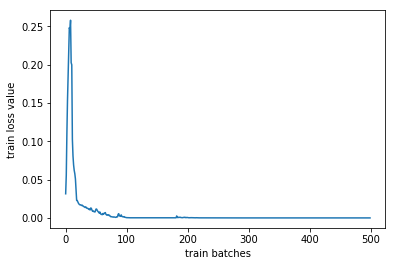

In [0]:
plt.plot(t_loss_history)

plt.ylabel('train loss value')
plt.xlabel('train batches')

plt.show()

In [0]:
test_loss = []
for train_epoch_num, train_epoch in enumerate(generate_epoch(train_X, train_y, 1, 128)):
  for train_batch_num, (batch_X, batch_y) in enumerate(train_epoch):
    loss = 0
    p = fw(batch_X, batch_y)
    print(p)
    loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=p, labels= batch_y))
    bloss = (loss/128)
  test_loss.append(bloss)

tf.Tensor(
[[-13.6841955  -13.4219885  -13.711524   ...   2.0606859   -2.207641
  -13.633846  ]
 [-13.637561   -13.550079   -14.012177   ...   2.5237226   -6.3801694
  -13.567944  ]
 [-13.682084   -13.77179    -14.183525   ...   2.7521276   13.575354
  -13.739816  ]
 ...
 [-10.395074   -10.546428   -10.885821   ...  -5.3196087   12.838566
  -10.561732  ]
 [-11.691525   -11.627308   -11.794419   ...   4.4635153   -0.5219212
  -11.733229  ]
 [-13.073224   -13.338928   -13.481073   ...  -0.76699924   8.710459
  -13.066405  ]], shape=(128, 37), dtype=float32)
tf.Tensor(
[[-17.168985   -16.977589   -17.563375   ...  11.808264     0.85489696
  -17.211412  ]
 [-12.597093   -12.521985   -12.827556   ...   4.6536922    1.526659
  -12.51619   ]
 [-13.811156   -13.616852   -13.904601   ...   2.1351175   12.789604
  -13.910947  ]
 ...
 [-11.022982   -10.761906   -11.009429   ...   5.681772     5.9171095
  -11.077863  ]
 [-15.105015   -14.648195   -15.297137   ...  13.121843    10.006006
  -15.0960

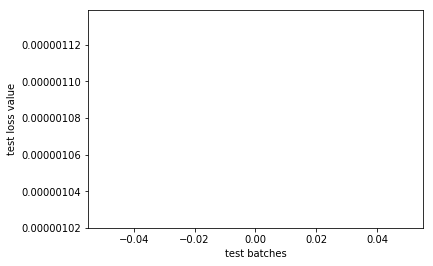

[<tf.Tensor: id=2152162, shape=(), dtype=float32, numpy=1.0794033e-06>]


In [0]:
plt.plot(test_loss)

plt.ylabel('test loss value')
plt.xlabel('test batches')

plt.show()

print(test_loss)